<a href="https://colab.research.google.com/github/mohamadhabash/Mowjaz-Multi-Topic-Labelling-Task/blob/main/Mowjaz_Multi_Topic_Labelling_Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cloning Github repos and installing requirements

In [ ]:
!git clone https://github.com/hseelawi/JUST-Mowjaz-Competition

In [ ]:
%cd JUST-Mowjaz-Competition/
%ls

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!unzip /content/drive/MyDrive/full_uni_sg_300_twitter.zip -d /content/JUST-Mowjaz-Competition/models/ # Get AraVec embeddings

In [ ]:
!git clone https://github.com/mohataher/arabic-stop-words.git # Get arabic stopwords

In [ ]:
!pip install -r requirements.txt

In [ ]:
!pip install num2words

In [ ]:
!pip install python-bidi arabic_reshaper

# Importing important libraries and getting Datasets

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, Bidirectional, GRU, LSTM, Conv1D, MaxPooling1D
from tensorflow.keras.models import Sequential
from sklearn.metrics import f1_score, jaccard_score
from embed_classer import embed

In [ ]:
df_train = pd.read_csv('/content/JUST-Mowjaz-Competition/Data/train.tsv', sep="\t")
df_dev = pd.read_csv("/content/JUST-Mowjaz-Competition/Data/validation.tsv", sep="\t")
df_test = pd.read_csv("/content/JUST-Mowjaz-Competition/Data/test_unlabaled.tsv", sep="\t")

df_train.head()

,Article,فن ومشاهير,أخبار,رياضة,اقتصاد,تكنولوجيا,اسلام و أديان,طقس,منوعات أخرى,صحة,مطبخ
0,ووفقا لموقع فوتبول إيطاليا تلاعب رونالدو بالضر...,0,0,1,0,0,0,0,0,0,0
1,"القاهرة- مصراوي: حيرت أسطورة وحش بحيرة ""لوخ ني...",0,0,0,0,1,0,0,1,0,0
2,"<p dir=""rtl""> سموذي الفراولة بالشوفان لفطور صح...",0,0,0,0,0,0,0,0,0,1
3,10 % نقداًتوزيعات «مجموعة الشارقة» الشارقة «ال...,0,0,0,1,0,0,0,0,0,0
4,خلق الله التفك ر في خلق الله من اسباب الايمان ...,0,0,0,0,0,1,0,0,0,0


In [ ]:
!git clone https://github.com/amueller/word_cloud

# Initialize Embedder

In [ ]:
seed_val = 32
tf.random.set_seed(seed_val)
max_sentence_len = 256

# Load Aravec 
embedd_path = '/content/JUST-Mowjaz-Competition/models/full_uni_sg_300_twitter.mdl'
embedd_size = 300

# Save Model
model_path = '/content/JUST-Mowjaz-Competition/models/bi_lstm.best.hdf5'

embedder = embed(embedd_path)

# Text Preprocessing

In [ ]:
import pyarabic.araby as araby
from pyarabic.araby import tokenize, is_arabicrange, strip_tashkeel

file = open('arabic-stop-words/list.txt', 'r')
stop_words = []

for line in file:
  line = line.strip()
  line = strip_tashkeel(line)
  stop_words.append(line)

file.close()

stop_words = set(stop_words)
stop_words.add('وذلك')
stop_words

In [ ]:
text = 'ذهب الولد من المنزل الى البيت'
text = tokenize(text)
text = ' '.join(word for word in text if word not in stop_words)
text

'الولد المنزل البيت'

In [ ]:
import re
import string
import pyarabic.araby as araby
from pyarabic.araby import tokenize, is_arabicrange, strip_tashkeel, strip_tatweel
from pyarabic.number import ArNumbers 
from num2words import num2words

def normalize_text(text):
    arabic_punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ'''
    english_punctuations = string.punctuation
    punctuations_list = arabic_punctuations + english_punctuations
    text = text.strip()
    text = strip_tashkeel(text)
    text = strip_tatweel(text)
    
    # remove extra spaces
    text = re.sub(' +', ' ', text)

    # remove html tags
    text = re.sub(re.compile('<.*?>'), ' ', text)

    # remove twitter usernames, web addresses
    text = re.sub(r"#[\w\d]*|@[.]?[\w\d]*[\'\w*]*|https?:\/\/\S+\b|"
                                              r"www\.(\w+\.)+\S*|", '', text)
    
    # strip repeated chars (extra vals)
    text = re.sub(r'(.)\1+', r"\1\1", text)

    # separate punctuation from words and remove not included marks
    text = " ".join(re.findall(r"[\w']+|[?!,;:]", text))
    
    text = ''.join(c for c in text if c not in punctuations_list)
    
    # remove meaningless words and stop words
    text = tokenize(text)
    text = ' '.join(word for word in text if len(word)>=3 and word not in stop_words)

    # replace characters to match aravec pre-trained model
    search = ["أ","إ","آ","ة","_","-","/",".","،",'"',"ـ","'","ى","\\",'\n', '\t','&quot;','?','؟','!']
    replace = ["ا","ا","ا","ه"," "," ","","","","","","","ي","",' ', ' ',' ',' ? ',' ؟ ',' ! ']
    text = text.replace('وو', 'و')
    text = text.replace('يي', 'ي')
    text = text.replace('اا', 'ا')
    
    for i in range(0, len(search)):
        text = text.replace(search[i], replace[i])

    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("گ", "ك", text)

  
    # tranform numbers to arabic words
    # text = tokenize(text)
    # text = ' '.join(num2words(int(c), lang='ar') if c.isdigit() else c for c in text)

    #remove numbers
    text = ''.join(i for i in text if not i.isdigit())
    # remove nonarabic words
    text = ' '.join(tokenize(text, conditions=is_arabicrange))
    # remove extra spaces
    text = re.sub(' +', ' ', text)

    return text

In [ ]:
num2words(25, lang='ar')

'خمسة و عشرون'

In [ ]:
X_train = np.array([normalize_text(text) for text in df_train.Article.values])
Y_train = df_train[df_train.columns[1:]].values

X_dev = np.array([normalize_text(text) for text in df_dev.Article.values])
Y_dev = df_dev[df_dev.columns[1:]].values

X_samples = pd.Series(X_train[:501])


In [ ]:
df_train.Article[10]

'<p>عمان 4 كانون الأول (بترا) - تكون الأجواء اليوم باردة نسبياً وغائمة جزئياً في أغلب المناطق، ولطيفة الحرارة في الأغوار والبحر الميت، وتكون الرياح شمالية غربية خفيفة السرعة، ومع ساعات الليل المتأخرة تتهيأ الفرصة لهطول زخات خفيفة ومتفرقة من المطر في شمال المملكة وأجزاء من المناطق الوسطى.وحسب تقرير دائرة الأرصاد الجوية، تكون الأجواء غدا باردة نسبياً وغائمة جزئياً إلى غائمة أحياناً، وتسقط بمشيئة الله الأمطار بين الحين والآخر في المناطق الشمالية والوسطى، تمتد تدريجياً لتشمل أجزاء من جنوب وشرق المملكة، وتكون الرياح غربية الى شمالية غربية معتدلة السرعة تنشط على فترات.ويطرأ انخفاض قليل على درجات الحرارة يوم الجمعة، وتكون الأجواء باردة نسبياً وغائمة جزئياً، ويتوقع سقوط زخات من المطر في مناطق متفرقة من المملكة، وتكون الرياح شمالية غربية معتدلة السرعة تنشط أحياناً.وتتراوح درجات الحرارة الكبرى والصغرى في عمان اليوم من 16 إلى 6 درجات مئوية، وفي المناطق الشمالية من 16 الى 8، وفي المناطق الجنوبية من 17 إلى 7، وفي خليج العقبة من 26 الى 14 درجة مئوية. -- (بترا)ي ع/ب ط04/12/2019 08:18:45</p>'

In [ ]:
X_samples[10]

'عمان الاول بترا الاجواء بارده نسبيا وغائمه جزئيا اغلب المناطق ولطيفه الحراره الاغوار والبحر الميت وتكون الرياح شماليه غربيه خفيفه السرعه ساعات الليل المتاخره تتهيا الفرصه لهطول زخات خفيفه ومتفرقه المطر المملكه واجزاء المناطق الوسطي وحسب تقرير دائره الارصاد الجويه الاجواء بارده نسبيا وغائمه جزئيا غائمه احيانا وتسقط بمشيئه الله الامطار الحين والاخر المناطق الشماليه والوسطي تمتد تدريجيا لتشمل اجزاء جنوب وشرق المملكه وتكون الرياح غربيه شماليه غربيه معتدله السرعه تنشط فترات ويطرا انخفاض قليل درجات الحراره الجمعه وتكون الاجواء بارده نسبيا وغائمه جزئيا ويتوقع سقوط زخات المطر مناطق متفرقه المملكه وتكون الرياح شماليه غربيه معتدله السرعه تنشط احيانا وتتراوح درجات الحراره الكبري والصغري عمان درجات مئويه المناطق الشماليه المناطق الجنوبيه خليج العقبه درجه مئويه بترا ط'

# Data Augmentation Approach

In [ ]:
# import gensim
# import random
# from nltk import ngrams

# t_model = gensim.models.Word2Vec.load('/content/JUST-Mowjaz-Competition/models/full_uni_sg_300_twitter.mdl')
# vocab = t_model.vocabulary.load('/content/JUST-Mowjaz-Competition/models/full_uni_sg_300_twitter.mdl')

# X_train_gen = []
# words = tokenize(X_train[10])
# words = [word for word in words if word in vocab]
# new_sentence = []
# for word in words:
#   most_similar = t_model.wv.most_similar(word, topn=10)
#   new_sentence.append(most_similar[random.randint(0,3)][0])

In [ ]:
# new_sentence = ' '.join(new_sentence)
# new_sentence = ' '.join(tokenize(new_sentence, conditions=is_arabicrange))
# new_sentence

# Data Visualization

(-0.5, 399.5, 199.5, -0.5)

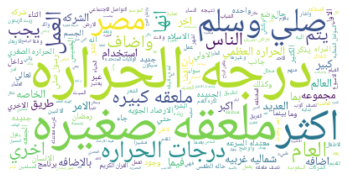

In [ ]:
import matplotlib.pyplot as plt
import arabic_reshaper
from wordcloud import WordCloud
from bidi.algorithm import get_display

# d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()

text = ' '.join(X_train)
text.strip()
text = arabic_reshaper.reshape(text)
text = get_display(text)

wordcloud = WordCloud(font_path='/content/JUST-Mowjaz-Competition/word_cloud/examples/fonts/NotoNaskhArabic/NotoNaskhArabic-Regular.ttf',
                      background_color="white", contour_color='steelblue', max_words=2000).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


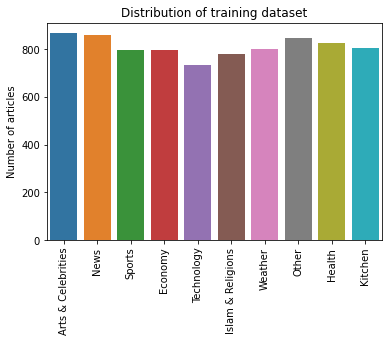

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

categories = ['Arts & Celebrities', 'News', 'Sports', 'Economy', 'Technology', 'Islam & Religions', 'Weather', 'Other', 'Health', 'Kitchen']
y = df_train[df_train.columns[1:]].sum()

bar_plot = sns.barplot(categories, y)
plt.setp(bar_plot.get_xticklabels(), rotation=90)
plt.ylabel("Number of articles")
plt.title("Distribution of training dataset")
plt.show()

# Text Vectorization

In [ ]:
X_train = embedder.embed_batch(X_train, max_sentence_len)
X_dev = embedder.embed_batch(X_dev, max_sentence_len)

# Create and train model

In [ ]:
def create_model(max_sentence_len, embedd_size, num_labels=10):
    sentence = keras.Input(shape=(max_sentence_len, embedd_size), name='sentence')
    forward_layer = GRU(300)
    backward_layer = GRU(300, go_backwards=True)

    model = Sequential()
    model.add(sentence)
    model.add(Dropout(0.2))
    model.add(Bidirectional(forward_layer, backward_layer=backward_layer))
    model.add(Dense(300, activation='sigmoid'))
    model.add(Dense(num_labels, activation='sigmoid'))
    model.compile(optimizer=Adam(0.0005), loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
earlystopping_callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=model_path,
    monitor='val_accuracy',
    mode='max',
    save_weights_only=True,
    save_best_only=True,
    verbose=1)

In [ ]:
model = create_model(max_sentence_len, embedd_size)
history = model.fit(X_train,
          Y_train,
          epochs=8,
          batch_size=50,
          validation_data = (X_dev, Y_dev),
          shuffle=True, 
          callbacks=[earlystopping_callback, checkpoint_callback])

Epoch 1/8
154/154 [==============================] - 118s 749ms/step - loss: 0.3779 - accuracy: 0.2784 - val_loss: 0.1687 - val_accuracy: 0.7155

Epoch 00001: val_accuracy did not improve from 0.85251
Epoch 2/8
154/154 [==============================] - 111s 721ms/step - loss: 0.1410 - accuracy: 0.7446 - val_loss: 0.1121 - val_accuracy: 0.7929

Epoch 00002: val_accuracy did not improve from 0.85251
Epoch 3/8
154/154 [==============================] - 111s 720ms/step - loss: 0.0984 - accuracy: 0.8136 - val_loss: 0.1013 - val_accuracy: 0.8274

Epoch 00003: val_accuracy did not improve from 0.85251
Epoch 4/8
154/154 [==============================] - 109s 707ms/step - loss: 0.0855 - accuracy: 0.8411 - val_loss: 0.0894 - val_accuracy: 0.8316

Epoch 00004: val_accuracy did not improve from 0.85251
Epoch 5/8
154/154 [==============================] - 111s 720ms/step - loss: 0.0785 - accuracy: 0.8520 - val_loss: 0.0883 - val_accuracy: 0.8347

Epoch 00005: val_accuracy did not improve from 0.8

In [ ]:
model.load_weights('/content/JUST-Mowjaz-Competition/models/bi_lstm.best.hdf5')

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_3 (Dropout)          (None, 256, 300)          0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 600)               1083600   
_________________________________________________________________
dense_6 (Dense)              (None, 300)               180300    
_________________________________________________________________
dense_7 (Dense)              (None, 10)                3010      
Total params: 1,266,910
Trainable params: 1,266,910
Non-trainable params: 0
_________________________________________________________________


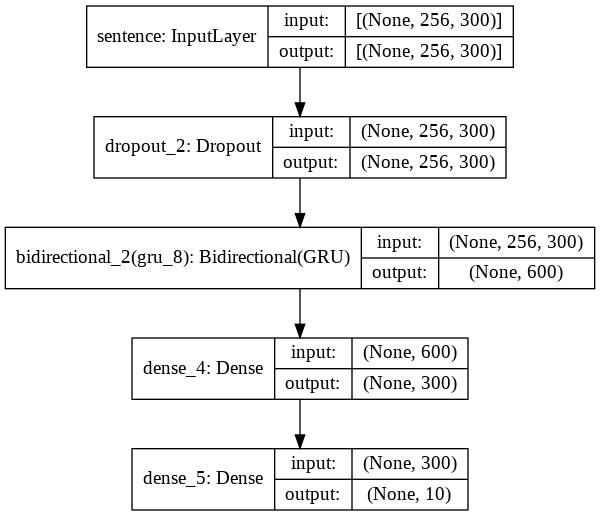

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

Text(0.5, 0, 'epoch')

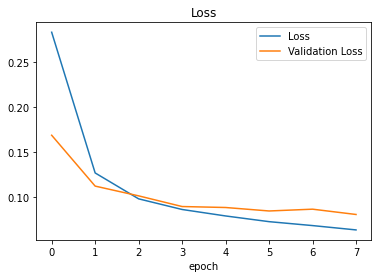

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Loss','Validation Loss'])
plt.title('Loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

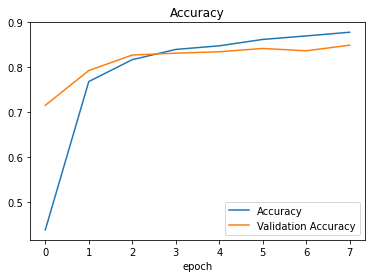

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Accuracy','Validation Accuracy'])
plt.title('Accuracy')
plt.xlabel('epoch')

In [ ]:
preds = model.predict(X_dev) > 0.3
print("F1 macro:   {}".format(round(f1_score(Y_dev, preds, average="macro"), 3)))
print("F1 micro:   {}".format(round(f1_score(Y_dev, preds, average="micro"), 3)))
print("F1 samples: {}".format(round(f1_score(Y_dev, preds, average="samples"), 3)))

F1 macro:   0.865
F1 micro:   0.861
F1 samples: 0.872


In [ ]:
X_test = np.array([normalize_text(text) for text in df_test.Article.values])
X_test = embedder.embed_batch(X_test, max_sentence_len)
preds = model.predict(X_test) > 0.3

In [ ]:
df = pd.DataFrame(data=preds, index=None, columns=None, dtype=int)
df.to_csv("Data/outputs/answer.tsv", header=False, index=False, sep="\t")